In this notebook, we show an example of our code implementation in calculating the gravitational waveform induced by a particle falling radially into a Kerr black hole along its spin axis (i.e. $\theta=0$ or $z$-axis). The particle has zero initial velocity at infinity, which we refer to as rest limit in the paper. It also means the orbital energy per mass is $\mathcal{E}=1$.

In [1]:
using GeneralizedSasakiNakamura
using SpinWeightedSpheroidalHarmonics
using DifferentialEquations
using Statistics
using CubicSplines
using QuadGK
using Plots, LaTeXStrings

Construct the source term 

$\mathcal{W}_{nn}=f_0(r)e^{i\chi(r)}+\int_{r}^\infty f_1(r_1)e^{i\chi(r_1)}d r_1+\int_r^\infty dr_1\int_{r_1}^\infty f_2(r_2)e^{i\chi(r_2)}dr_2$,

where

$f_0(r)=\frac{\mathscr{A}}{\omega^2}w_{nn}^{(0)}(r)$, 

$f_1(r)=\frac{\mathscr{A}}{\omega^2}\left[{w_{nn}^{(0)}}'(r)+i\xi(r)w_{nn}^{(0)}(r)+w_{nn}^{(1)}(r)\right]$, 

$f_2(r)=\frac{\mathscr{A}}{\omega^2}\left[{w_{nn}^{(1)}}'(r)+i\xi(r)w_{nn}^{(1)}(r)\right]$,

$\chi(r)=\omega \left[t(r)+r_*(r)\right]$,

with

$w_{nn}^{(0)}(r)=\frac{1}{2}r^2\rho\bar{\rho}^2u^r \mathscr{L}_1^\dagger\left[\rho^{-4}\mathscr{L}_2^\dagger\left(\rho^3S\right)\right]$,

$w_{nn}^{(1)}(r)=w_{nn}^{(0)}(r)\left(\frac{\mathcal{N}}{u^r}\right)'\frac{u^r}{\mathcal{N}}+{w_{nn}^{(0)}}'(r)+i\xi(r)w_{nn}^{(0)}(r)$.

In our case $\xi(r)\equiv 0$, $\mathscr{A}=-1$ and 

$u^t=\frac{r^2+a^2}{\Delta^2}$,

$u^r=-\sqrt{\frac{2r}{r^2+a^2}}$,

$\mathcal{N}=u^t+\frac{\Sigma}{\Delta}u^r=\frac{r^2+a^2}{\Delta}\left(1-\sqrt{\frac{2r}{r^2+a^2}}\right)$.

One can see that $\mathcal{N}(r\to r_+)$ is non-vanishing but hard to compute directly because both the denominator and the term in the bracket are zero in the limit. We also need its first- and second-order derivatives with respect to $r$. So we expand them into series of $x=r-r_+$ when $r_*\to-\infty$, namely

$\mathcal{N}(r\to r_+)=n^0_0+n^0_1x+n^0_2x^2+\dots$,

$\mathcal{N}'(r\to r_+)=n^1_0+n^1_1x+n^1_2x^2+\dots$,

$\mathcal{N}''(r\to r_+)=n^2_0+n^2_1x+n^2_2x^2+\dots$.

If $x<3\times10^{-3}$, we can reach the $10^{-12}$ relative tolerance by truncating at $n_5^{0,1,2}$.

In [2]:
function N_expansions(r, a)
    rp = 1 + sqrt(1 - a^2)
    x = r - rp
    # We find it more convenient to work with ν = arcsin(a)
    ν = asin(a)
    if x < 3e-3
        # The expansion coefficients of N
        n00 = 1 / 2
        n01 = 1 / (8 + 8 * sec(ν))
        n02 = (sin(ν)^2 - cos(ν)) / (16 * (1 + cos(ν))^2)
        n03 = (5 * cos(ν)^3 - 8 * sin(ν)^2) / (128 * (1 + cos(ν))^3)
        n04 = (-7 * cos(ν) + (19 + 15 * cos(ν)) * sin(ν)^2 - 7 * sin(ν)^4)/(256 * (1 + cos(ν))^4)
        n05 = (21 * cos(ν) - 4 * (15 + 19 * cos(ν) + 7 * cos(2 * ν)) * sin(ν)^2
             + 21 * cos(ν) * sin(ν)^4)/(1024 * (1 + cos(ν))^5)
        N = n00 + n01 * x + n02 * x^2 + n03 * x^3 + n04 * x^4 + n05 * x^5

        # The expansion coefficients of N'
        n10 = 1/(8 + 8 * sec(ν))
        n11 = -(1/64) * (-1 + 2 * cos(ν) + cos(2 * ν)) * sec(ν/2)^4
        n12 = (3 * (-16 + 15 * cos(ν) + 16 * cos(2 * ν) + 5 * cos(3 * ν)) * sec(ν/2)^6)/4096
        n13 = -(((-55 + 26 * cos(ν) + 48 * cos(2 * ν) + 30 * cos(3 * ν) 
            + 7 * cos(4 * ν)) * sec(ν/2)^8)/8192)
        n14 = (5 * (-368 + 74 * cos(ν) + 256 * cos(2 * ν) + 241 * cos(3 * ν) 
            + 112 * cos(4 * ν) + 21 * cos(5 * ν)) * sec(ν/2)^10)/524288
        n15 = -((3 * (-1234 + 36 * cos(ν) + 639 * cos(2 * ν) + 810 * cos(3 * ν) 
            + 562 * cos(4 * ν) + 210 * cos(5 * ν) + 33 * cos(6 * ν)) * sec(ν/2)^12)/2097152)
        Np = n10 + n11 * x + n12 * x^2 + n13 * x^3 + n14 * x^4 + n15 * x^5

        # The expansion coefficients of N''
        n20 = -(1/64) * (-1 + 2 * cos(ν) + cos(2 * ν)) * sec(ν/2)^4
        n21 = (3 * (-16 + 15 * cos(ν) + 16 * cos(2 * ν) + 5 * cos(3 * ν)) * sec(ν/2)^6)/2048
        n22 = -((3 * (-55 + 26 * cos(ν) + 48 * cos(2 * ν) + 30 * cos(3 * ν) 
            + 7 * cos(4 * ν)) * sec(ν/2)^8)/8192)
        n23 = (5 * (-368 + 74 * cos(ν) + 256 * cos(2 * ν) + 241 * cos(3 * ν) + 112 * cos(4 * ν) 
            + 21 * cos(5 * ν)) * sec(ν/2)^10)/131072
        n24 = -((15 * (-1234 + 36 * cos(ν) + 639 * cos(2 * ν) + 810 * cos(3 * ν) + 562 * cos(4 * ν) 
            + 210 * cos(5 * ν) + 33 * cos(6 * ν)) * sec(ν/2)^12)/2097152)
        n25 = (1/134217728) * 21 * (-33472 - 2777 * cos(ν) + 12192 * cos(2 * ν) + 19697 * cos(3 * ν) 
            + 18112 * cos(4 * ν) + 10107 * cos(5 * ν) + 3168 * cos(6 * ν) + 429 * cos(7 * ν)) * sec(ν/2)^14
        Npp = n20 + n21 * x + n22 * x^2 + n23 * x^3 + n24 * x^4 + n25 * x^5
    else
        N = 1/(1 + (sqrt(2) * r)/sqrt(r * (a^2 + r^2)))
        Np = (-a^2 * r + r^3)/(sqrt(2) * sqrt(r * (a^2 + r^2)) * (sqrt(2) * r + sqrt(r * (a^2 + r^2)))^2)
        Npp = (r * (a^4 * (6 * r + sqrt(2) * sqrt(r * (a^2 + r^2))) - r^4 * (2 * r 
            + 3 * sqrt(2) * sqrt(r * (a^2 + r^2))) + 2 * a^2 * r^2 * (6 * r + 5 * sqrt(2) 
            * sqrt(r * (a^2 + r^2))))) / (4 * (r * (a^2 + r^2))^(3/2) * (sqrt(2) * r + sqrt(r * (a^2 + r^2)))^3)
    end
    return N, Np, Npp
end

N_expansions (generic function with 1 method)

We define 

$P = \frac{1}{2}r^2\rho\bar{\rho}^2=-\frac{r^2}{2(r-ia)(r+ia)^2}$,

$Q = \mathscr{L}_1^\dagger\left[\rho^{-4}\mathscr{L}_2^\dagger\left(\rho^3S\right)\right] = 4(ia-r)\left.\frac{\partial^2{}_{-2}S_{\ell 0}^{a\omega}(\theta)}{\partial\theta^2}\right|_{\theta=0}$,

$U = u^r$.

The components in $f_{0,1,2}$ will be

$w_{nn}^{(0)} = PUQ$,

${w_{nn}^{(0)}}' = P'UQ+PU'Q+PUQ'$,

${w_{nn}^{(0)}}''=P''UQ+PU''Q+PUQ''+2P'U'Q+2P'UQ'+2PU'Q'$,

${w_{nn}^{(1)}} = w_{nn}^{(0)}\left(\frac{\mathcal{N}'}{\mathcal{N}}-\frac{U'}{U}\right)+{w_{nn}^{(0)}}'$,

${w_{nn}^{(1)}}' = {w_{nn}^{(0)}}'(\frac{\mathcal{N}'}{\mathcal{N}}-\frac{U'}{U})+{w_{nn}^{(0)}}\left[\frac{\mathcal{N}''}{\mathcal{N}}-\left(\frac{\mathcal{N}'}{\mathcal{N}}\right)^2-\frac{U''}{U}+\left(\frac{U'}{U}\right)^2\right]+{w_{nn}^{(0)}}''$.

Numerically, we give $f_{0,1,2}$ as functions of $r$

In [3]:
function f_terms(a, ω, S2)
    function f_r(r)
        N, Np, Npp = N_expansions(r, a)

        P = - r^2 / (2 * (-im*a + r) * (im*a + r)^2)
        Pp = (r * (-2*a^2 - im*a*r + r^2))/(2 * (-im*a + r)^2 * (im*a + r)^3)
        Ppp = (im * (a^4 + 2*im*a^3*r - 6*a^2*r^2 - 2*im*a*r^3 + r^4))/((a - im*r)^4 * (a + im*r)^3)

        Q = 4 * (im * a - r) * S2
        Qp =  - 4 * S2
        Qpp = 0

        U = -((sqrt(2) * r)/sqrt(r * (a^2 + r^2)))
        Up = (r * (-a^2 + r^2))/(sqrt(2) * (r * (a^2 + r^2))^(3/2))
        Upp = (r * (a^4 + 10 * a^2 * r^2 - 3 * r^4))/(2 * sqrt(2) * (r * (a^2 + r^2))^(5/2))

        wnn0 = P*U*Q
        dwnn0 = Pp*U*Q + P*Up*Q + P*U*Qp
        ddwnn0 = Ppp*U*Q + P*Upp*Q + P*U*Qpp + 2*Pp*Up*Q + 2*Pp*U*Qp + 2*P*Up*Qp
        wnn1 = wnn0 * (Np/N - Up/U) + dwnn0
        dwnn1 = dwnn0 * (Np/N - Up/U) + wnn0 * (Npp/N - (Np/N)^2 - Upp/U + (Up/U)^2) + ddwnn0

        f0 = - wnn0 / ω^2
        f1 = - (wnn1 + dwnn0) / ω^2
        f2 = - dwnn1 / ω^2

        return f0, f1, f2
    end
    return f_r
end

f_terms (generic function with 1 method)

One can reproduce Figure 4(a) of our paper by

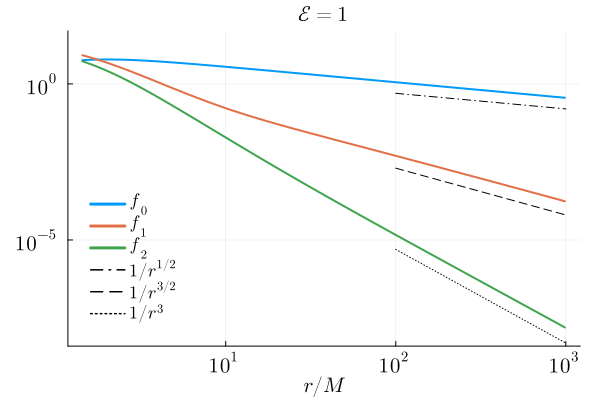

In [4]:
rs_values = range(-100, 1000, 1000)
a = 0.9
ω = 0.5
S2 = 1
f_r = f_terms(a, ω, S2)
r_values = [r_from_rstar(a, r) for r in rs_values]
f0_values = [abs(f_r(r)[1]) for r in r_values]
f1_values = [abs(f_r(r)[2]) for r in r_values]
f2_values = [abs(f_r(r)[3]) for r in r_values]
r_benchmark = 10 .^range(2, 3, 20)
r_to_minus_half = [5*r^(-0.5) for r in r_benchmark]
r_to_minus_onehalf = [2*r^(-1.5) for r in r_benchmark]
r_to_minus_three = [5*r^(-3.0) for r in r_benchmark]

f_terms_rest = plot(r_values,
    f0_values,
    xlabel = L"r/M",
    label = L"f_0",
    legendfont = font(12,"Computer Modern"),
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    yscale =:log10,
    xscale =:log10,
    linewidth=2.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm)
plot!(r_values,
    f1_values,
    xlabel = L"r/M",
    label = L"f_1",
    legendfont = font(12,"Computer Modern"),
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    yscale =:log10,
    xscale =:log10,
    linewidth=2.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm)
plot!(r_values,
    f2_values,
    xlabel = L"r/M",
    label = L"f_2",
    legendfont = font(12,"Computer Modern"),
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    yscale =:log10,
    xscale =:log10,
    linewidth=2.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm)
plot!(r_benchmark,
    r_to_minus_half,
    xlabel = L"r/M",
    label = L"1/r^{1/2}",
    legendfont = font(12,"Computer Modern"),
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    yscale =:log10,
    xscale =:log10,
    linewidth=1.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm,
    color =:black,
    linestyle =:dashdot)
plot!(r_benchmark,
    r_to_minus_onehalf,
    xlabel = L"r/M",
    label = L"1/r^{3/2}",
    legendfont = font(12,"Computer Modern"),
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    yscale =:log10,
    xscale =:log10,
    linewidth=1.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm,
    color =:black,
    linestyle =:dash)
plot!(r_benchmark,
    r_to_minus_three,
    xlabel = L"r/M",
    label = L"1/r^3",
    title = L"\mathcal{E}=1",
    legendfont = font(12,"Computer Modern"),
    legendfontsize=12,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:bottomleft,
    formatter=:latex,
    yscale =:log10,
    xscale =:log10,
    linewidth=1.0,
    color =:black,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm,
    linestyle =:dot,
    ylim = (4e-9, 50))

The phase term 

$t(r_*)=\int_{r_*^{\rm in}}^{r_*}\frac{d t}{d r} \frac{d r}{d \tilde{r}_*} d \tilde{r}_*=\int_{r_*^{\rm in}}^{r_*}\frac{u^t}{u^r} \frac{\Delta}{r^2+a^2} d \tilde{r}_* = \int_{r_*^{\rm in}}^{r_*}\frac{1}{u^r} d \tilde{r}_*$ 

can be solved numerically from some initial value $t(r_*^{\rm in})= - r_*^{\rm in}$ outwards to make sure $v(r_*^{\rm in})=t(r_*^{\rm in})+r_*^{\rm in}=0$.

In [5]:
function t_of_rs(rs_out, a)
    function f!(du, u, p, rs)
        r = r_from_rstar(a, rs)
        ur = -((sqrt(2) * r)/sqrt(r * (a^2 + r^2)))
        du[1] = 1 / ur 
    end
    rs_in = min(-100, 50*log10(1-a))
    t0 = - rs_in
    u0 = [t0]
    prob = ODEProblem(f!, u0, (rs_in, rs_out))
    sol = solve(prob, abstol=1e-8, reltol=1e-8)

    return sol, rs_in, rs_out
end

t_of_rs (generic function with 1 method)

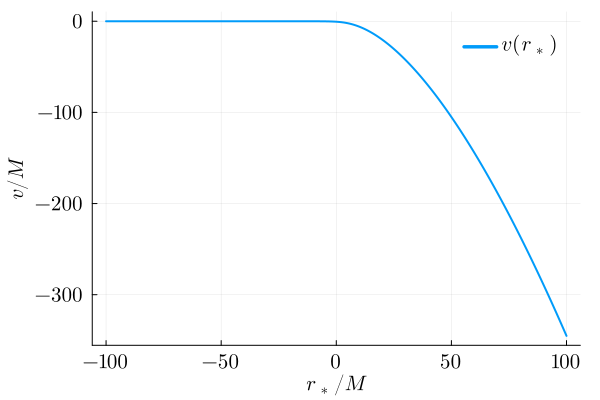

In [6]:
trs = t_of_rs(1000, 0.9)
rs_values = range(-100, 100, 1000)
v_values = [trs[1](rs)[1]+rs for rs in rs_values]
plot(rs_values,
    v_values,
    xlabel = L"r_*/M",
    ylabel = L"v/M",
    label = L"v(r_*)",
    legendfont = font(12,"Computer Modern"),
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    linewidth=2.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm)

We precompue the integrals in $\mathcal{W}_{nn}$ as ODE solving problems. The truncation of the integral $r_*^{\rm max}\to\infty$ can be set to some large numbers to make sure the convergence and precision.

In [7]:
function precompute_W_integral(trs, f, a, omega)
    trs_sol, rsmin, rsmax = trs
    function f1!(du, u, p, rs)
        r = r_from_rstar(a, rs)
        du[1] = - f(r)[2] * exp(1im * omega * (trs_sol(rs)[1] + rs)) * (r^2 - 2*r + a^2)/(r^2 + a^2)
    end
    function f2!(du, u, p, rs)
        r = r_from_rstar(a, rs)
        du[1] = - f(r)[3] * exp(1im * omega * (trs_sol(rs)[1] + rs)) * (r^2 - 2*r + a^2)/(r^2 + a^2)
    end
    
    u0 = ComplexF64[0.0]

    prob1 = ODEProblem(f1!, u0, (rsmax, rsmin))
    sol1 = solve(prob1, abstol=1e-8, reltol=1e-8)
    

    prob2 = ODEProblem(f2!, u0, (rsmax, rsmin))
    sol2 = solve(prob2, abstol=1e-8, reltol=1e-8)

    function f2r!(du, u, p, rs)
        r = r_from_rstar(a, rs)
        du[1] = - sol2(rs)[1] * (r^2 - 2*r + a^2)/(r^2 + a^2)
    end

    prob2r = ODEProblem(f2r!, u0, (rsmax, rsmin))
    sol2r = solve(prob2r, abstol=1e-8, reltol=1e-8)

    return sol1, sol2r
end

precompute_W_integral (generic function with 1 method)

In [8]:
function Wnn_integrals(l, a, omega; rsout = 10000)
    SH = spin_weighted_spheroidal_harmonic(-2, l, 0, a*omega)
    S2 = SH(0, 0; theta_derivative=2)

    f = f_terms(a, omega, S2)

    rsout = max(rsout, 100pi*abs(omega)^(-1.0))
    trs = t_of_rs(rsout * 3, a)

    Wnn1, Wnn2 = precompute_W_integral(trs, f, a, omega)

    function Wnn(rs)
        r = r_from_rstar(a, rs)
        χ =  omega * (trs[1](rs)[1] + rs)
        phase = exp(1im * χ)
        W = f(r)[1] * phase + Wnn1(rs)[1] + Wnn2(rs)[1]
        return W
    end
    
    return Wnn
end

Wnn_integrals (generic function with 1 method)

One can reproduce Figure 4(b) of our paper by

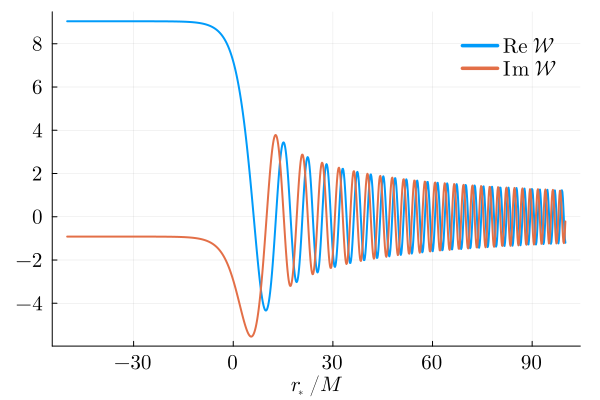

In [9]:
rs_values = range(-50, 100, 1000)
l = 2
a = 0.9
ω = 0.5
W_1 = Wnn_integrals(l, a, ω)
W_values = [W_1(rs)[1] for rs in rs_values]
W1 = plot(rs_values,
    real.(W_values),
    xlabel = L"r_{\!\!\!\! _*}/M",
    label = L"\mathrm{Re}\ \mathcal{W}",
    legendfont = font(12,"Computer Modern"),
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    linewidth=2.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm)
plot!(rs_values,
    imag.(W_values),
    xlabel = L"r_{\!\!\!\! _*}/M",
    label = L"\mathrm{Im}\ \mathcal{W}",
    legendfont = font(12,"Computer Modern"),
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    linewidth=2.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm)

Then we do Green's function convolution integral defined by

$\frac{X_{\ell 0\omega}^\infty}{c_0}=\frac{1}{2i\omega B_{\rm SN}^{\rm inc}}\int_{r_*^{\rm in}}^{r_*^{\rm out}}\frac{\Delta X_{\ell 0 \omega}^{\rm in}(r_*)\mathcal{W}_{nn}(r_*)}{r^2(r^2+a^2)^{3/2}}e^{-i\omega r_*}d r_*$,

where $r_*^{\rm in}\to -\infty$ and $r_*^{\rm out}\to +\infty$. According to our numerical experiment, $r_*^{\rm in}={\rm min}\left(-50,50\lg(1-a)\right)$ and $r_*^{\rm out}={\rm max}\left(5000, \frac{50\pi}{|\omega|}\right)$ are sufficient for us to achieve $10^{-8}$ relative error.

To avoid integrating too far away, we define a new function "baseline" to find the baseline of the oscillatory integral and iterate the process by doubling the $r_*^{\rm out}$ until we find the baseline.

In [10]:
function baseline(f, x0, x1; npoints=1000)

    function compute_baseline(y::Vector{Float64})
        raw_extrema = []
        for i in 2:length(y)-1
            if y[i] > y[i-1] && y[i] > y[i+1]
                push!(raw_extrema, (i, y[i], :max))
            elseif y[i] < y[i-1] && y[i] < y[i+1]
                push!(raw_extrema, (i, y[i], :min))
            end
        end
        if isempty(raw_extrema)
            return NaN
        end

        cleaned = [raw_extrema[1]]
        for i in 2:length(raw_extrema)
            if raw_extrema[i][3] != cleaned[end][3]
                push!(cleaned, raw_extrema[i])
            end
        end

        types = [ext[3] for ext in cleaned]
        nmax, nmin = count(==( :max), types), count(==( :min), types)
        if nmax > nmin
            cleaned = filter(e -> e[3] == :min || e !== last(cleaned), cleaned)
        elseif nmin > nmax
            cleaned = filter(e -> e[3] == :max || e !== last(cleaned), cleaned)
        end

        maxima = [y for (_, y, t) in cleaned if t == :max]
        minima = [y for (_, y, t) in cleaned if t == :min]

        if isempty(maxima) || isempty(minima)
            return NaN
        end

        return (mean(maxima) + mean(minima)) / 2
    end

    xs = range(x0, x1; length=npoints)
    ys = f.(xs)

    baseline_real = compute_baseline(real.(ys))
    baseline_imag = compute_baseline(imag.(ys))

    return baseline_real + im * baseline_imag
end

baseline (generic function with 1 method)

In [11]:
function SN_convolution(l, omega, a; rsout = 5000, rsin = - 50)
    s = -2
    m = 0
    rsin = min(rsin, 50*log10(1-a))
    rsout = max(50pi*abs(omega)^(-1.0), rsout)
    X = GSN_radial(s, l, m, a, omega, IN, rsin, rsout)
    Binc = X.incidence_amplitude
    W = Wnn_integrals(l, a, omega; rsout = rsout)
    function integrand!(du, u, p, rs)
        r = r_from_rstar(a, rs)
        du[1] = W(rs)[1] * X(rs) * (r^2 - 2*r + a^2)/((r^2 + a^2)^(3/2)*r^2) * exp(-1im * omega * rs)
    end
    u0 = ComplexF64[0.0]
    prob = ODEProblem(integrand!, u0, (rsin, rsout))
    sol = solve(prob, abstol=1e-8, reltol=1e-8)
    function soln(rs)
        return sol(rs)[1] / (2im*omega*Binc)
    end
    Δr = 0.1*rsout
    result = baseline(soln, rsout-Δr, rsout)

    if abs(result) === NaN
        return SN_convolution(l, omega, a; rsout = 2 * rsout, rsin = rsin)
    else
        return result
    end
end

SN_convolution (generic function with 1 method)

In [12]:
@time SN_convolution(2, 1e-3, 0.9)

  8.870353 seconds (44.25 M allocations: 1.943 GiB, 5.65% gc time, 67.73% compilation time: <1% of which was recompilation)


1.384211107451771 - 0.9020032118235283im

In [13]:
@time SN_convolution(2, 0.5, 0.9)

  1.083295 seconds (5.46 M allocations: 244.566 MiB, 33.42% gc time, 1.12% compilation time)


-0.011973774895345117 + 0.035421356682873745im

We compute the amplitude spectrum $\left|\frac{X_{\ell 0\omega}^\infty}{c_0}\right|$ as a function of $\omega$ with $\ell=2$ and $a=0.9$ as an example. The code will run for about 3 minutes on an Apple m2 air.

In [14]:
omega_values_1 = range(-1.2, -0.01, 95)
omega_values_2 = range(-0.01, -0.001, 6)
omega_values_3 = range(0.001, 0.01, 6)
omega_values_4 = range(0.01, 1.2, 95)
omega_values = union(omega_values_1, omega_values_2, omega_values_3, omega_values_4)
@time AmpX_values_2_rest = [SN_convolution(2, omega, 0.9) for omega in omega_values]
println()

184.407300 seconds (1.21 G allocations: 53.729 GiB, 10.54% gc time, 0.01% compilation time)



One can reproduce the $\ell=2$ curve in our Figure 6(a) by

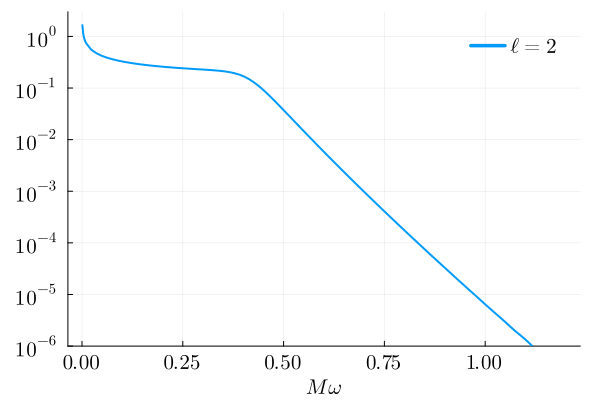

In [15]:
N = Int64(length(omega_values)/2)
Amp_head_on_rest = plot(omega_values[N+1:2N],
    abs.(AmpX_values_2_rest[N+1:2N]),
    xlabel = L"M\omega",
    label = L"\ell=2",
    legendfont = font(12,"Computer Modern"),
    yscale =:log10,
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    linewidth=2.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm,
    ylim = (1e-6, 3))

One can also reproduce the $\ell=2$ curve of the energy spectrum

$\left(\frac{d \mathcal{E}}{d\omega}\right)_\ell^\infty=8\omega^2\mu^2\left(\left|\frac{X_{\ell 0\omega}^\infty}{c_0}\right|^2+\left|\frac{X_{\ell 0-\omega}^\infty}{c_0}\right|^2\right)$

in our Figure 6(b) by

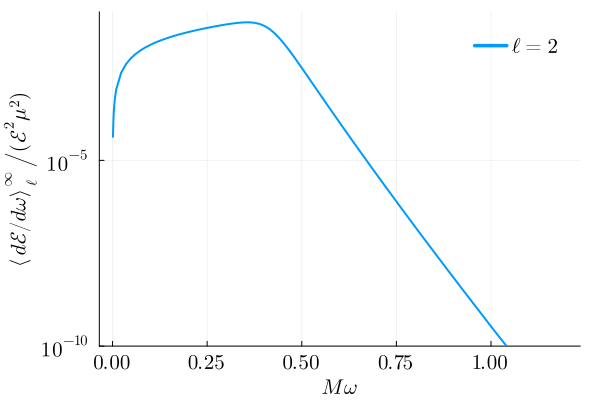

In [16]:
Eomega_rest_2 = zeros(N)
for i in 1:N
    Eomega_rest_2[i] = (abs2(AmpX_values_2_rest[N-i+1])+abs2(AmpX_values_2_rest[N+i]))*omega_values[N+i]^2*8
end
Spectrum_head_on_rest = plot(omega_values[N+1:2N],
    Eomega_rest_2,
    xlabel = L"M\omega",
    ylabel = L"\left.\left\langle d\mathcal{E}/d\omega\right\rangle^\infty_\ell\right/(\mathcal{E}^2\mu^2)",
    label = L"\ell=2",
    legendfont = font(12,"Computer Modern"),
    yscale =:log10,
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    linewidth=2.0,
    left_margin = 2Plots.mm,
    right_margin = 3Plots.mm,
    ylim = (1e-10, 1e-1))

To facilitate a smoother inverse Fourier transform, we use "CubicSpline" to interpolate the off-grid $\omega$ points to compute

$h_+-ih_\times =\sum_\ell \int_{-\infty}^\infty \tilde{h}_\ell(\omega)e^{-i\omega u} d\omega$,

where

$\tilde{h}(\omega)=\frac{8\mu}{r}\frac{X_{\ell 0\omega}^\infty}{c_0}{}_{-2}S_{\ell 0}^{a\omega}(\theta,\varphi)$.

Here we still use $\ell=2$ as an example.

Since we have

$\left|\frac{X_{\ell 0\omega}}{c_0}\right|\sim \omega^{(\ell -3)/3}$

which is divergent for $\ell=2$ in the zero frequency limit. We can fix the error of $\ell=2$ oriented from truncating $|\omega_{\rm min}|=10^{-3}$ analytically by

$\int_{0}^{\omega_{\rm min}}\omega^{-1/3}d\omega=\frac{3}{2}\omega_{\rm min}^{2/3}$.

One can check this analytical fix by removing it from the following inverse FT function and plot the waveform. When it is removed, the waveform is not calibrated to zero (which could be misunderstood as memory effect) when $u>0$.

In [17]:
function hu(omega, amplitude, a, l, θ, ϕ)
    N = Int64(length(omega))
    amp_swsh = zeros(ComplexF64, N)
    for i in 1:N
        amp_swsh[i] = amplitude[i] * spin_weighted_spheroidal_harmonic(-2, l, 0, a*omega[i])(θ, ϕ)
    end
    spline_re = CubicSpline(omega, real.(amp_swsh))
    spline_im = CubicSpline(omega, imag.(amp_swsh))
    amp(ω) = spline_re(ω) + 1im * spline_im(ω)
    function h_u(u)
        h1 = quadgk(ω -> amp(ω) * exp(-1im * ω * u) * 8, 1e-3, omega[end])[1]
        h2 = quadgk(ω -> amp(ω) * exp(-1im * ω * u) * 8, omega[1], -1e-3)[1]
        h = h1 + h2
        ### fix error
        if l == 2
            h += (amp(1e-3) + amp(-1e-3)) * (1e-3)^(2/3) * 3/2
        end
        ###
        return h
    end
    return h_u
end

hu (generic function with 1 method)

One can reproduce the $\ell=2$ waveform in our Figure 8 by

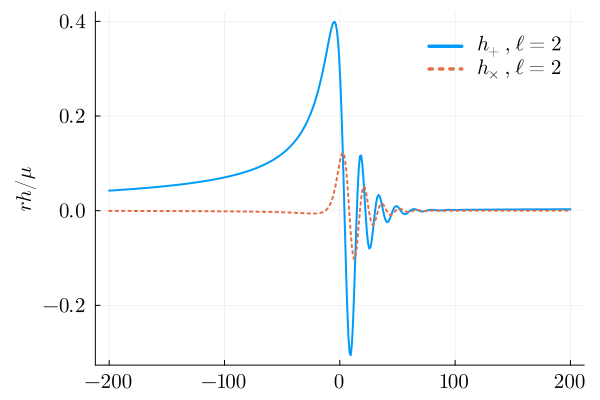

In [18]:
u_values = range(-200, 200, 400)
h2 = hu(omega_values, AmpX_values_2_rest, 0.9, 2, 0.5pi, 0.0)
h2_values = [h2(u) for u in u_values]
Waveform_head_on_rest_2 = plot(u_values,
    real.(h2_values),
    ylabel = L"rh/\mu",
    label = L"\ \ h_{\!\!\! +},\ell=2",
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    linewidth= 2.0,
    left_margin = 4Plots.mm,
    right_margin = 2Plots.mm)
plot!(u_values,
    -imag.(h2_values),
    ylabel = L"rh/\mu",
    label = L"\ \ h_{\!\!\! \times},\ell=2",
    legendfontsize=14,
    xguidefontsize=14,
    yguidefontsize=14,
    xtickfontsize=14,
    ytickfontsize=14,
    foreground_color_legend=nothing,
    background_color_legend=nothing,
    legend=:topright,
    formatter=:latex,
    linestyle = :dot,
    linewidth= 2.0,
    left_margin = 4Plots.mm,
    right_margin = 2Plots.mm)